In [0]:
# !git clone https://github.com/6clc/cframeSegment.git

In [0]:
# cd cframeSegment/

In [0]:
# !python  setup.py install

In [3]:
index = 0
environments = ['700_linux', 'colab', '410']
print('use {}'.format(environments[index]))

use 700_linux


In [4]:
if index == 0:
    root_dir = '/run/media/hanshan/data2'
elif index == 1:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive'
    !ls '/content/drive/My Drive/Data'
elif index == 2:
    root_dir = '/home/he'

data_root_dir = root_dir + '/Data'
summary_root_dir = root_dir + '/SummaryWiter'

In [5]:
from cframe.datamanager import DataloaderManager
from cframe.datamanager import DataConfiger
from cframe.models import ModelManager
from cframe.models import ModelConfiger
from cframe.datamanager import standard_transform
from cframe.learner import Learner
from cframe.utils.summary_writer import SummaryWriter
from cframe.metrics.visual_segment_metrics import iou, dice_score
import torch.nn as nn
import torch
import numpy as np
from PIL import Image
import os
import warnings
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
has_path=os.path.exists

In [6]:
if not has_path:
    os.makedirs(summary_root_dir)

In [7]:
DataConfiger.set_data_root_dir(data_root_dir)
DataConfiger.get_all_data_name()

['MIT1003', 'DUT-OMRON', 'SkyImage', 'CamVid']

In [8]:
data_config = DataConfiger.get_data_config('CamVid')
data_config

{'root_dir': '/run/media/hanshan/data2/Data',
 'dataset_dir': 'DataSets',
 'csv_dir': 'CSVs',
 'data_name': 'CamVid',
 'data_info': {'name': 'CamVid', 'n_classes': 13},
 'normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]},
 'resize': (224, 224),
 'train': {'batch_size': 16, 'num_workers': 8},
 'valid': {'batch_size': 16, 'num_workers': 8}}

In [9]:
if index == 0:
    data_config['resize'] = (512, 512)
data_config['train']['batch_size'] = 4
data_config['valid']['batch_size'] = 4
data_config

{'root_dir': '/run/media/hanshan/data2/Data',
 'dataset_dir': 'DataSets',
 'csv_dir': 'CSVs',
 'data_name': 'CamVid',
 'data_info': {'name': 'CamVid', 'n_classes': 13},
 'normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]},
 'resize': (512, 512),
 'train': {'batch_size': 4, 'num_workers': 8},
 'valid': {'batch_size': 4, 'num_workers': 8}}

In [10]:
dl_manager = DataloaderManager(data_config)

In [11]:
dl_manager.segment_trans_list.append(standard_transform.CamVidReLabel())

In [12]:
model_names = ModelConfiger.get_model_names()
model_names

dict_keys(['tiramisu', 'unet_resnet'])

In [0]:
model_config = ModelConfiger.get_model_config('unet_resnet')
# model_config['config']['n_classes'] = 1

In [0]:
model = ModelManager.get_model(model_config)
model = nn.DataParallel(model, device_ids=[0]).cuda()

In [0]:
ModelConfiger.get_loss_names()

In [0]:
ce_config = ModelConfiger.get_loss_config('SymmetricLovaszLoss')
ce_config

In [0]:
loss = ModelManager.get_loss(ce_config)
loss = loss.cuda()

In [0]:
from torch.optim import Adam

In [0]:
optimizer = Adam(model.parameters(), lr=1e-4, 
                betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0)

In [0]:
learner = Learner(model, loss, dice_score, dl_manager, optimizer=optimizer, label='segment')

train_loss,valid_loss,metric
0.36,0.23,97.98 %
0.17,0.13,98.41 %
0.09,0.06,98.42 %
0.06,0.05,98.46 %
0.05,0.05,98.47 %
0.05,0.05,98.53 %
0.05,0.05,98.37 %
0.05,0.05,98.45 %
0.05,0.05,98.55 %
0.05,0.05,98.46 %


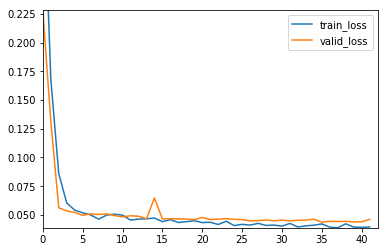

In [28]:
learner.train(num_epoches=30, log_nth=100)

In [29]:
log_dir = os.path.join(summary_root_dir, 'camvid_sky_unet_resnet')
if not has_path(log_dir):
    os.makedirs(log_dir)
model_save_path = os.path.join(log_dir, 'model.pth')
if os.path.exists(model_save_path):
    print('already has this model, please review')
else:
    print('save model')
    learner.save(model_save_path)

save model


In [0]:
learner.load(model_save_path, remove_module=False)

In [43]:
data = dict(
    img=data_root_dir + '/DataSets/CamVid/img/0016E5_05310.png',
    segment=data_root_dir + '/DataSets/CamVid/segment/0016E5_05310.png'
)

In [52]:
data = dict(
    img=data_root_dir + '/DataSets/SkyImage/src/sky2609.jpg',
    segment=data_root_dir + '/DataSets/SkyImage/label/1567586880452.png'
)

In [48]:
color_table = [ 255, 0, 0, 0, 0, 255]

In [55]:
img = Image.open(data['img'])
pred = Image.open(data['segment'])

In [56]:
pred = pred.convert('L')

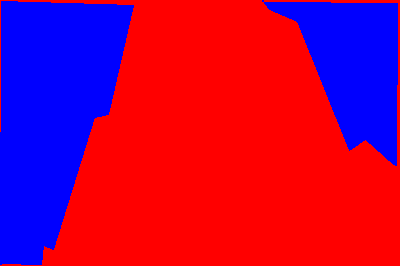

In [57]:
pred = pred.convert('P')
pred.putpalette(color_table)
pred

In [58]:
np.unique(pred)

array([0, 1], dtype=uint8)

In [59]:
img = np.array(img)
img.shape

(266, 400, 3)

In [60]:
img = np.array(img)
img =  dl_manager.img_trans_list[0](img)
img = Image.fromarray(img)

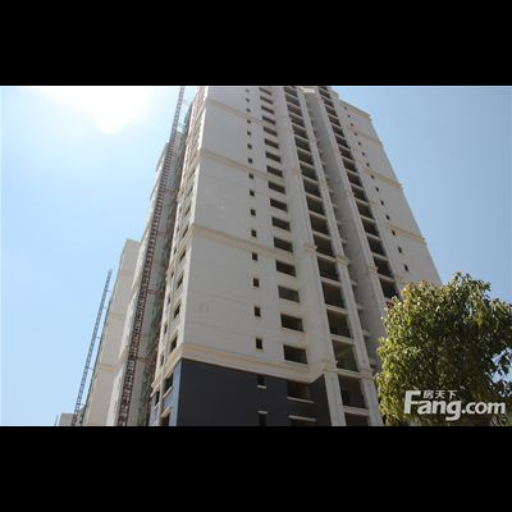

In [61]:
img

In [43]:
pred.shape

(360, 480, 1)

In [0]:
pred = np.squeeze(pred)

In [0]:
pred = Image.fromarray(pred)
pred = pred.convert('P')
pred.putpalette([255, 0, 0, 0, 0, 255])

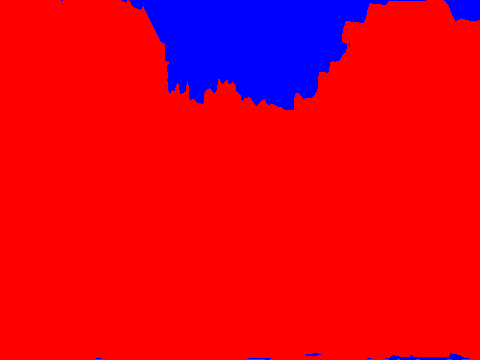

In [46]:
pred